In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates

# validation modules
import experiment
import metrics

# requires cleanair
sys.path.append("../containers")
from cleanair.models import ModelData

In [2]:
# read experiment from file
name = 'laptop_test'
cluster = 'laptop'
experiment_dir = '../run_model/experiments/'
exp = experiment.experiment_from_dir(name, cluster)

In [3]:
# load the data_model objects
secret_fp = "../terraform/.secrets/db_secrets.json"
model_data_list = []
for data_id in exp.experiment_df.data_id.unique():
    data_dir = experiment_dir + exp.name + '/data/data' + str(data_id)
    model_data = ModelData(config_dir=data_dir, secretfile=secret_fp)
    model_data_list.append(model_data)
    
    train_arrays = model_data.get_training_data_arrays()
    pred_arrays = model_data.get_pred_data_arrays()
    print('pred index:', pred_arrays['index'])
    print('train x shape:', train_arrays['X'].shape)
    print('pred x shape:', pred_arrays['X'].shape)
    print(model_data.normalised_pred_data_df.measurement_start_utc.unique())

pred index: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887],
           dtype='int64', length=3398)
train x shape: (6716, 4)
pred x shape: (3398, 4)
['2019-11-03 00:00:00' '2019-11-03 01:00:00' '2019-11-03 02:00:00'
 '2019-11-03 03:00:00' '2019-11-03 04:00:00' '2019-11-03 05:00:00'
 '2019-11-03 06:00:00' '2019-11-03 07:00:00' '2019-11-03 08:00:00'
 '2019-11-03 09:00:00' '2019-11-03 10:00:00' '2019-11-03 11:00:00'
 '2019-11-03 12:00:00' '2019-11-03 13:00:00' '2019-11-03 14:00:00'
 '2019-11-03 15:00:00' '2019-11-03 16:00:00' '2019-11-03 17:00:00'
 '2019-11-03 18:00:00' '2019-11-03 19:00:00' '2019-11-03 20:00:00'
 '2019-11-03 21:00:00' '2019-11-03 22:00:00' '2019-11-03 23:00:00']
pred index: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887],
           dtype='int64', len

In [4]:
# get a list of model data objects with updated prediction columns
updated_preds = []


for index, row in exp.experiment_df.iterrows():
    row = exp.experiment_df.loc[index]
    pid = row['param_id']
    model = row['model_name']
    did = row['data_id']
#     y_test = np.load(exp.data_config[did]['y_test_fp'])
    Y_pred = np.load(row['y_pred_fp'])
    y_mean = Y_pred[0, :, 0]
    y_var = Y_pred[0, :, 1]
    
    # look at shapes
    data_config = exp.data_config[did]
    x_test = np.load(data_config['x_test_fp'])
    y_test = np.load(data_config['y_test_fp'])
    print("Xs :", x_test.shape)
    print("Ys :", y_test.shape)
    
    # update model_data
    normalised_df = model_data_list[did].normalised_pred_data_df.copy()
    print("normalised df shape:", normalised_df.shape)
    
    gb = normalised_df.dropna(axis=1).groupby(['measurement_start_utc', 'point_id'])
#     print(gb.filter(lambda x: x['lat'].count() == 4).count())
    
    predict_data_dict = model_data_list[did].get_pred_data_arrays(dropna=True).copy()
    print('pred data dict x', predict_data_dict['X'].shape)
    
    # Create new dataframe with predictions
    predict_df = pd.DataFrame(index=predict_data_dict['index'])
    print("Pred index shape:", predict_df.shape)
    print("Y pred shape:", Y_pred.shape)
    print("Y mean shape:", np.reshape(y_mean, y_mean.shape[0]).shape)
    print("Y var shape:", y_var.shape)
    predict_df['predict_mean'] = np.reshape(y_mean, y_mean.shape[0])
    predict_df['predict_var'] = np.reshape(y_var, y_var.shape[0])
    predict_df['fit_start_time'] = exp.data_config[did]['pred_start_date']
    predict_df['tag'] = 0
    
    normalised_pred_data_df = pd.concat([model_data_list[did].normalised_pred_data_df, predict_df], axis=1, ignore_index=False)
    updated_preds.append(normalised_pred_data_df)


Xs : (3398, 4)
Ys : (3398, 1)
normalised df shape: (3888, 20)
pred data dict x (3398, 4)
Pred index shape: (3398, 0)
Y pred shape: (1, 3398, 2)
Y mean shape: (3398,)
Y var shape: (3398,)
      Unnamed: 0                              point_id measurement_start_utc  \
1507        1507  59205e7a-7ce5-40b7-992b-c97e27c5d32a   2019-11-03 19:00:00   
2484        2484  995ae411-c5b5-486f-90ba-903f91b8def2   2019-11-03 12:00:00   
1654        1654  63587c73-d6a4-46b3-9819-b46c113ef571   2019-11-03 22:00:00   

     source                                           location       lon  \
1507   laqn  0101000020e6100000c5a978de049bc8bf0d00940644b5... -0.192231   
2484   laqn  0101000020e6100000fed4c851894cca3fd400d929a9c2...  0.205461   
1654   laqn  0101000020e6100000284dd881b77daebf837ae50181bd... -0.059553   

            lat          date_opened  date_closed  value_1000_flat  ...  \
1507  51.416138  2011-06-29 00:00:00          NaN     3.120995e+06  ...   
2484  51.520787  1995-12-08 00:00:00 

In [9]:
i = 0
preds = updated_preds[i]
preds['measurement_start_utc'] = pd.to_datetime(preds['measurement_start_utc'])
gb = preds.groupby('point_id')
print(preds.columns)

Index(['Unnamed: 0', 'point_id', 'measurement_start_utc', 'source', 'location',
       'lon', 'lat', 'date_opened', 'date_closed', 'value_1000_flat',
       'value_500_flat', 'value_200_flat', 'value_100_flat', 'value_10_flat',
       'epoch', 'NO2', 'epoch_norm', 'lat_norm', 'lon_norm',
       'value_1000_flat_norm', 'predict_mean', 'predict_var', 'fit_start_time',
       'tag'],
      dtype='object')


In [10]:
def plot_pretty_timeseries(time, series, ax, sigmas=None, locator=dates.DayLocator(interval=1)):
    ax.plot_date(time, series, ',', linestyle='-')
    ax.xaxis.grid(True, which="major")
#     ax.xaxis.set_major_locator(locator)
#     ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n%m'))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
    
    if not sigmas is None:
        factor = 2
        y_min = series - factor*np.sqrt(sigmas)
        y_max = series + factor*np.sqrt(sigmas)
        ax.fill_between(time, y_min, y_max, color='orange', alpha=0.5)
        
        
    return ax

times: (96,)
means: (96,)
sigmas: (96,)


/Users/pohara/Documents/repos/clean-air-infrastructure/python-virtual-environments/env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



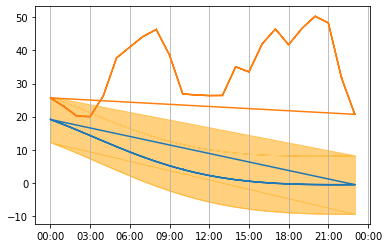

times: (24,)
means: (24,)
sigmas: (24,)


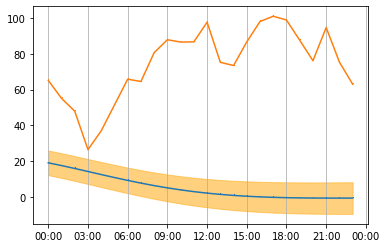

times: (24,)
means: (24,)
sigmas: (24,)


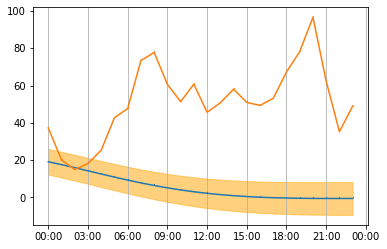

times: (24,)
means: (24,)
sigmas: (24,)


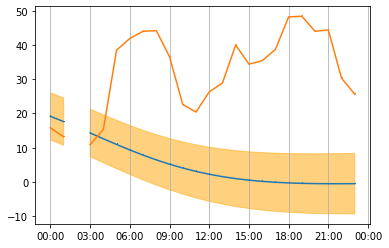

times: (24,)
means: (24,)
sigmas: (24,)


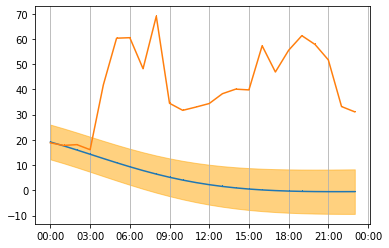

times: (24,)
means: (24,)
sigmas: (24,)


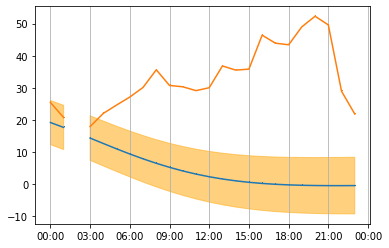

times: (24,)
means: (24,)
sigmas: (24,)


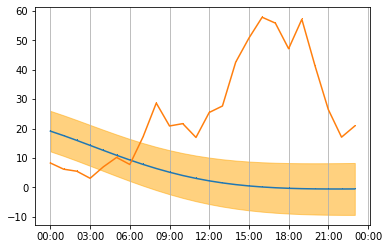

times: (24,)
means: (24,)
sigmas: (24,)


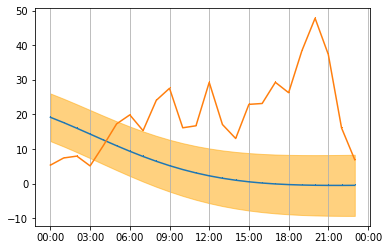

times: (24,)
means: (24,)
sigmas: (24,)


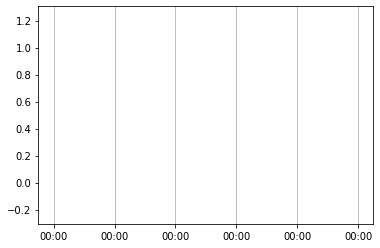

times: (24,)
means: (24,)
sigmas: (24,)


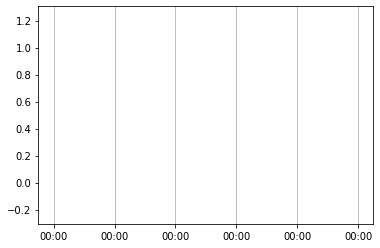

times: (24,)
means: (24,)
sigmas: (24,)


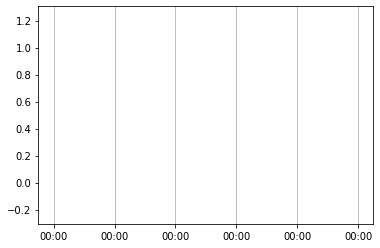

In [7]:
count = 0
for point, row in gb:
    fig0, ax = plt.subplots()
    times = row['measurement_start_utc']
    means = row['predict_mean']
    sigmas = row['predict_var']
    print("times:", times.shape)
    print("means:", means.shape)
    print("sigmas:", sigmas.shape)
    locator = dates.HourLocator(interval=6)
    plot_pretty_timeseries(times, means, ax, sigmas=sigmas, locator=locator)
    plot_pretty_timeseries(times, row['NO2'], ax, locator=locator)
    plt.show()
    count += 1
    if count > 10:
        break

0016baa9-b443-47a9-93c0-6ef19de90f37 0     19.149103
1     19.149103
2     17.616422
3     17.616422
4     15.983952
        ...    
91    -0.535456
92    -0.538911
93    -0.538911
94    -0.520507
95    -0.520507
Name: predict_mean, Length: 96, dtype: float64
08b18953-9787-4b6e-ad51-367589401ecd 96     19.149103
97     17.616422
98     15.983952
99     14.297700
100    12.601475
101    10.935180
102     9.333512
103     7.825091
104     6.432014
105     5.169798
106     4.047660
107     3.069058
108     2.232433
109     1.532069
110     0.959011
111     0.501970
112     0.148180
113    -0.115834
114    -0.303604
115    -0.428193
116    -0.501795
117    -0.535456
118    -0.538911
119    -0.520507
Name: predict_mean, dtype: float64
09286d1a-f3fa-4578-ae91-10e0edbacdd5 120    19.149103
121    17.616422
122    15.983952
123    14.297700
124    12.601475
125    10.935180
126     9.333512
127     7.825091
128     6.432014
129     5.169798
130     4.047660
131     3.069058
132     2.232433
13

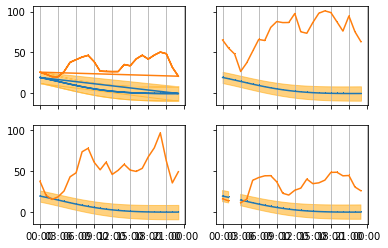

In [8]:
n = 2 # number of rows
c = 2 # number of columns
fig, axs = plt.subplots(n, c, sharex=True, sharey=True)
i = 0
j = 0
for point, row in gb:
    print(point, row['predict_mean'])
    plot_pretty_timeseries(row['measurement_start_utc'], row['predict_mean'], axs[i, j], sigmas=row['predict_var'], locator=dates.HourLocator(interval=6))
    plot_pretty_timeseries(row['measurement_start_utc'], row['NO2'], axs[i, j], locator=dates.HourLocator(interval=6))
    i += j % c
    j += 1
    j = j % c
    if i == n:
        break